In [1]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
# Генерація зваженого графа
num_nodes = 10
num_edges = 20
G = nx.gnm_random_graph(num_nodes, num_edges)
for (u, v) in G.edges():
    G[u][v]['weight'] = random.uniform(0.1, 1.0)

In [3]:
# Конвертація графа в формат даних PyTorch Geometric
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
edge_weight = torch.tensor([G[u][v]['weight'] for u, v in G.edges()], dtype=torch.float)
x = torch.eye(G.number_of_nodes(), dtype=torch.float)  # Identity features
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

In [4]:
num_features = data.num_node_features
num_classes = 4  # Приклад: 4 класи для кластеризації
data.y = torch.tensor([random.randint(0, num_classes - 1) for _ in range(num_nodes)], dtype=torch.long)


# Ініціалізація шарів GAT
gat1 = GATConv(num_features, 8, heads=8, dropout=0.6)
gat2 = GATConv(8 * 8, num_classes, heads=1, concat=False, dropout=0.6)

# Визначення оптимізатора
optimizer = torch.optim.Adam([
    {'params': gat1.parameters()},
    {'params': gat2.parameters()}
], lr=0.005, weight_decay=5e-4)

# Прямий прохід (forward pass)
x = F.elu(gat1(data.x, data.edge_index))  # Важливо: передаємо тільки x та edge_index
x = gat2(x, data.edge_index)
out = F.log_softmax(x, dim=1)

In [5]:
# Тренування
optimizer.zero_grad()
loss = F.nll_loss(out, data.y)  # data.y повинні бути мітки кластерів
loss.backward()
optimizer.step()

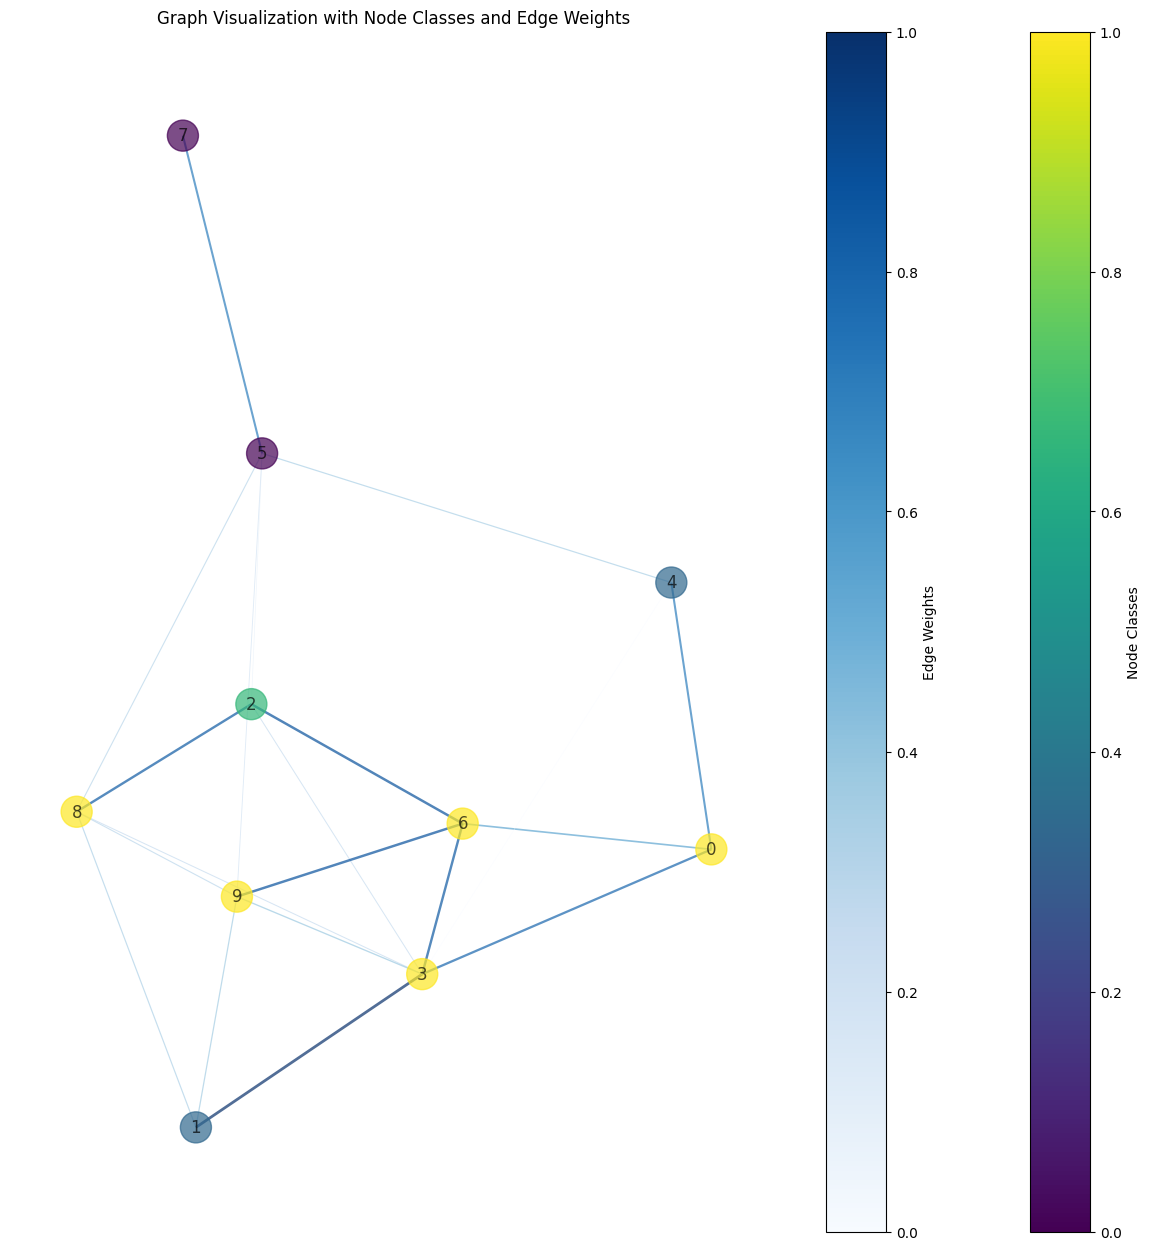

In [6]:
# Візуалізація графа
pos = nx.spring_layout(G)

# Отримання ваг ребер
weights = [G[u][v]['weight'] for u, v in G.edges()]

# Отримання класів вузлів для кольорів
node_classes = [data.y[i].item() for i in range(num_nodes)]

# Нормалізація ваг для колірної карти
edge_weights_normalized = [weight / max(weights) for weight in weights]

# Візуалізація з кольорами та товщиною ребер
plt.figure(figsize=(12, 12))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=node_classes,
    node_size=500,
    cmap=plt.cm.viridis,  # Колірна карта для вузлів
    edge_color=edge_weights_normalized,
    edge_cmap=plt.cm.Blues,  # Колірна карта для ребер
    width=[weight * 2 for weight in edge_weights_normalized],  # Товщина ребер
    alpha=0.7
)
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), ax=plt.gca(), label='Node Classes')
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), ax=plt.gca(), label='Edge Weights')
plt.title('Graph Visualization with Node Classes and Edge Weights')
plt.show()